野球の給与データセットは、Journal of Statistics Education（JSE）データアーカイブから入手できます。
このデータセットには、ピッチャーではなく、1991年と1992年の両方のシーズン中に少なくとも1つのゲームをプレイした
337人のメジャーリーグベースボール（MLB）プレーヤーの給与情報が含まれています。
この研究の目的は、野球選手の給料が彼の攻撃的な成績を反映しているかどうかを判断することです。
各プレイヤーについて、1992年シーズンからの給料と1991年シーズンからの12の攻撃統計が集められました。
これらの変数に加えて、自由機関と仲裁の適格性を識別する4つの指標変数があります。

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import Dropout

import pickle

Using TensorFlow backend.


In [2]:
data = pd.read_csv("baseball_data.csv")
data.columns = ("sarary", "batting avg", "OBR", "run", "hit", "double", "triple", "homerun", "RBI", 
                "fourball", "strikeout", "stolen", "error", "x13", "x14", "x15", "x16")
#OBP:出塁率
#RBI:打点
#run:得点

In [3]:
print(data.shape)
data.head()

(337, 17)


,sarary,batting avg,OBR,run,hit,double,triple,homerun,RBI,fourball,strikeout,stolen,error,x13,x14,x15,x16
0,3300,0.272,0.302,69,153,21,4,31,104,22,80,4,3,1,0,0,0
1,2600,0.269,0.335,58,111,17,2,18,66,39,69,0,3,1,1,0,0
2,2500,0.249,0.337,54,115,15,1,17,73,63,116,6,5,1,0,0,0
3,2475,0.260,0.292,59,128,22,7,12,50,23,64,21,21,0,0,1,0
4,2313,0.273,0.346,87,169,28,5,8,58,70,53,3,8,0,0,1,0


In [4]:
data.describe()

,sarary,batting avg,OBR,run,hit,double,triple,homerun,RBI,fourball,strikeout,stolen,error,x13,x14,x15,x16
count,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000
mean,1248.528190,0.257825,0.323973,46.697329,92.833828,16.673591,2.338279,9.097923,44.020772,35.017804,56.706231,8.246291,6.771513,0.397626,0.115727,0.192878,0.029674
std,1240.013309,0.039546,0.047132,29.020166,51.896322,10.452001,2.543336,9.289934,29.559406,24.842474,33.828784,11.664782,5.927490,0.490135,0.320373,0.395145,0.169938
min,109.000000,0.063000,0.063000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,230.000000,0.238000,0.297000,22.000000,51.000000,9.000000,0.000000,2.000000,21.000000,15.000000,31.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,740.000000,0.260000,0.323000,41.000000,91.000000,15.000000,2.000000,6.000000,39.000000,30.000000,49.000000,4.000000,5.000000,0.000000,0.000000,0.000000,0.000000
75%,2150.000000,0.281000,0.354000,69.000000,136.000000,23.000000,3.000000,15.000000,66.000000,49.000000,78.000000,11.000000,9.000000,1.000000,0.000000,0.000000,0.000000
max,6100.000000,0.457000,0.486000,133.000000,216.000000,49.000000,15.000000,44.000000,133.000000,138.000000,175.000000,76.000000,31.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
train_data = data.iloc[:300, 1:13].values.astype("float32")#訓練データ
test_data = data.iloc[300:, 1:13].values.astype("float32")#テストデータ

train_label = data["sarary"][:300].values.astype("float32")#訓練データのラベル
test_label = data["sarary"][300:].values.astype("float32")#テストデータのラベル

In [6]:
#正規化

stdc = StandardScaler()

#訓練データの平均と標準偏差
mean_train = np.mean(train_data, axis = 0)
std_train = np.std(train_data, axis = 0)
#ラベルの平均と標準偏差
mean_label = np.mean(train_label, axis = 0)
std_label = np.std(train_label, axis = 0)

#テストデータは訓練データの値で正規化
for column in range(test_data.shape[1]):
    test_data[:, column] = (test_data[:, column] - mean_train[column]) / std_train[column]
test_label = (test_label - mean_label) / std_label

#訓練データを正規化
train_data = stdc.fit_transform(train_data)
train_label = (train_label - mean_label) / std_label

In [7]:
len(train_data)

300

# k分割交差検証

In [8]:
k = 4#分割数
num_val_data = len(train_data) // k#検証データ数
num_epochs = 150
batch_size = 4

mae_all_scores = []
loss_all_scores = []
val_loss_all_scores = []

for num in range(k):
    print(num+1, "回目")
    
    #検証用データ
    val_data = train_data[num * num_val_data: (num + 1) * num_val_data]
    val_label = train_label[num * num_val_data: (num + 1) * num_val_data]
    
    #訓練用データ
    par_train_data = np.concatenate([train_data[: num * num_val_data], train_data[(num + 1) * num_val_data: ]], axis = 0)
    par_train_label = np.concatenate([train_label[: num * num_val_data], train_label[(num + 1) * num_val_data: ]], axis = 0)
    
    model = Sequential()
    model.add(Dense(4, activation="relu", input_shape=(train_data.shape[1], )))
    model.add(Dense(4, activation="relu"))
    model.add(Dense(1))
    
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    
    history = model.fit(par_train_data, par_train_label, 
                        epochs=num_epochs, 
                        batch_size=batch_size, 
                        validation_data=(val_data, val_label), 
                        verbose = 0
                       )
    
    
    mae_history = history.history["val_mean_absolute_error"]
    loss_history = history.history["loss"]
    val_loss_history = history.history["val_loss"]
    
    mae_all_scores.append(mae_history)
    loss_all_scores.append(loss_history)
    val_loss_all_scores.append(val_loss_history)


print("終了")

print("モデルを保存しています・・・")
#f = open("baseball_model","wb")
#pickle.dump(model, f)
#f.close
model.save("baseball_model.h5")
print("モデルを保存しました。")

1 回目
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
2 回目
3 回目
4 回目
終了
モデルを保存しています・・・
モデルを保存しました。


In [9]:
#f = open("baseball_model", "rb")
 
#model2 = pickle.load(f)

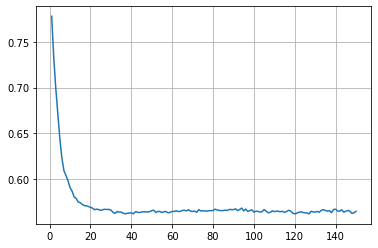

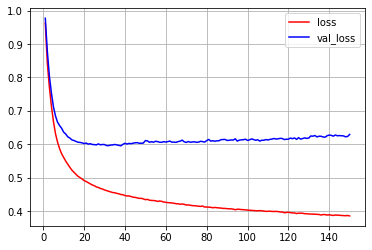

In [10]:
average_mae_history = [np.mean([x[i] for x in mae_all_scores]) for i in range(num_epochs)]
average_loss_history = [np.mean([x[i] for x in loss_all_scores]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in val_loss_all_scores]) for i in range(num_epochs)]

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.grid(True)
plt.show()

plt.plot(range(1, len(average_loss_history) + 1), average_loss_history, color = "red", label="loss")
plt.plot(range(1, len(average_val_loss_history) + 1), average_val_loss_history, color = "blue", label="val_loss")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
ans = model.predict(np.array([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]]))
print((ans * std_label) + mean_label)

[[-2078.921]]


In [12]:
ans2 = model.evaluate(test_data, test_label)
print(ans2)

37/37 [==============================] - 0s 52us/step
[0.4421756849498362, 0.5335227794743873]


In [13]:
print(std_train)
print(mean_train)

[3.7369091e-02 4.3865968e-02 2.8560400e+01 5.1223877e+01 1.0147821e+01
 2.6179805e+00 9.0631123e+00 2.9168533e+01 2.4886461e+01 3.3527500e+01
 1.1886300e+01 5.9678917e+00]
[ 0.25924     0.32521668 46.94       93.69334    16.78        2.4466667
  9.         44.1        35.193333   57.013332    8.576667    6.76      ]
